## Double Descent Phenomenon using Random Fourier Features

The objective of the following notebook is to present the **Double Descent Curve** represented in report of our project. We would work with the MNIST dataset which we downloaded from *Scikit-Learn* available datasets. This dataset contains 1797 samples of $8\times 8$ pictures which is approximately balanced.

The original data has 10 digits. We'll modify the task form classifyign individual digits to *separating curvy digits from those with angles*. So, Our task will be to separate 0, 3, 6, 8, 9 from 1, 2, 4, 5, 7. This leads to an approximate balance between positive and negative examples.

From **Belkin et al**:
<br>We first consider a popular class of nonlinear parametric models called random Fourier features (RFF), which can be viewed as a class of 2-layer neural networks with fixed weights in the first layer. The RFF model family **$H_N$** with *$N$* (complex-valued) parameters consists of functions **$h: R^d \rightarrow C$** of the form

<br><center> $h(x) = \displaystyle\sum_{k=1}^{N} a_k \phi (x; v_k)$    $\hspace{1cm}$ *where* $\hspace{1cm}$   $\phi(x;v_k) := e^{i<v_k,x>} $
    
<br>and the vectors $v_1,...,v_N$ are sampled independently from the standard normal distribution in $R^d$.

Rather than finding the complex valued coefficients $\{a_k\}_{k=1}^{N}$, we set the design matrix as follows:

$$\Phi = \begin{bmatrix} cos(v_1^Tx_1) & sin(v_1^Tx_1) & cos(v_2^Tx_1) & sin(v_2^Tx_1) & ... & cos(v_N^Tx_1) & sin(v_N^Tx_1) \\ 
                  cos(v_1^Tx_2) & sin(v_1^Tx_2) & cos(v_2^Tx_2) & sin(v_2^Tx_2) & ... & cos(v_N^Tx_2) & sin(v_N^Tx_2) \\ 
                  cos(v_1^Tx_3) & sin(v_1^Tx_3) & cos(v_2^Tx_3) & sin(v_2^Tx_3) & ... & cos(v_N^Tx_3) & sin(v_N^Tx_3) \end{bmatrix}$$
                  
Giving us a matrix $\Phi \in R^{n\times 2N}$ where we are following Belkin et al's notation with *n* number of data points and *N* number of random Fourier features. Note that because each feature (in our representation) contains a sine and a cosine, the total number of basis functions is *2N*. The frequencies of the features, as Belkin et al explain, should be sampled from a standard normal density.

So we can compute the output of the functions, denoted as $h(x)$, for each of the points using matrix multiplication:

<br><center> $h(x) = a^T\Phi(x)$
    
where $a \in R^N $ is a vector containing the elements $a_k$.

As **Belkin et al** suggests:

Our learning procedure using $H_N$ is as follows. Given data $(x_1, y_1), ..., (x_N, y_N)$ from $R^d \times R$, we find the predictor $h_{n,N} \in H_N$ via ERM with squared loss. That is, we minimize the empirical risk objective $\displaystyle\sum_{i=1}^{N} (h(x_i) - y_i)^2$ over all functions $h \in H_N$. When the minimizer is not unique (as is always the case when $2N > n$), we choose the minimizer whose coefficients $(a_1,...,a_N)$ have the minimum $l_2$ norm. This choice of norm is intended as an approximation to the RKHS norm $\lVert h \rVert _{H_\infty}$, which is generally difficult to compute for arbitrary functions in $H_N$.

In [1]:
using LinearAlgebra, Random, Statistics, CSV, DataFrames, Plots

In [2]:
function random_fourier_basis(X, V)
    arg = X*V
    Phi = zeros((size(X,1), 2*size(V,2)))
    Phi[:, 1:2:end] = cos.(arg) 
    Phi[:, 2:2:end] = sin.(arg)
    return Phi
end



function predict(X_test, a, V)
    Phi_test = random_fourier_basis(X_test, V)
    return Phi_test*a
end



function error_prediction(X, y, a, V)
    y_pred = predict(X, a, V)
    return mean((y_pred - y).^2)
end;

As mentioned above, we are minimizing the empirical risk. So the solution of the model would be the least-squares solution for $2N \leq n$. Also, for $2N > n$ which is the over-parameterized regime, as the solution is not unique, we return the solution with the least $l_2$ norm so that the problem's solution would be unique in this case as well. In julia, the backslash operator would do all the above statements in both cases and we don't need to justify the conditions.

In [3]:
function fit(X_train, y_train, N)
    d = size(X_train,2)
    V = randn((d, N))
    Phi_train = random_fourier_basis(X_train, V)
    a = Phi_train \ y_train
    return a, V
end;

Now we load the dataset and the corresponding labels. Also, we normalize features so that they fall in the same range. Finally, instead of labeling as **0,1**, we label the targets as **-1,+1** so that the squared loss between samples is greater; However **0,1** labels would work fine as well.

In [4]:
X = Matrix(CSV.read("data_X.csv", DataFrame))
X = X./std(X)
X = X/sqrt(size(X,2))

y = CSV.read("data_y.csv", DataFrame);
y_t = zeros((size(y,1), 1))
for i=1:size(y,1)
    y_t[i] = y[i,1] == 0 || y[i,1] == 3 || y[i,1] == 6 || y[i,1] == 8 || y[i,1] == 9
end

y = y_t;

Now we use 1000 samples for training the model and the other 797 samples for testing:

In [5]:
X_train = X[1:1000,:]
X_test = X[1001:end, :]
y_train = 2*y[1:1000] .- 1
y_test = 2*y[1001:end] .- 1;

We run the model for different number of features and save the errors of each run and finally plotting the results:

In [6]:
errors_test = zeros((2000, 1))
errors_train = zeros((2000, 1))
for N=1:2000
    Random.seed!(0) #set the random seed for reproducability
    a, V = fit(X_train, y_train, N)
    errors_test[N] = error_prediction(X_test, y_test, a, V)
    errors_train[N] = error_prediction(X_train, y_train, a, V)
end

Plotting the results:

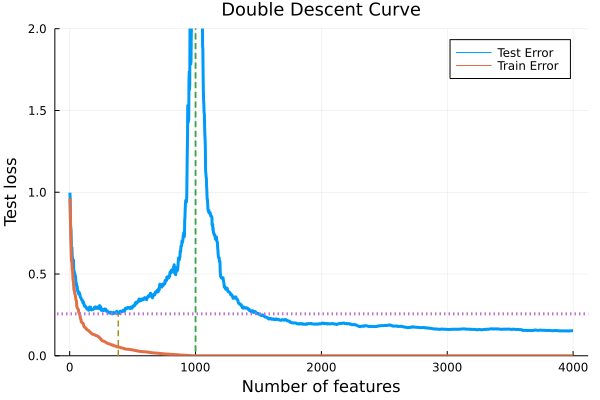

In [13]:
plot(2:2:4000, errors_test, linewidth=3, title="Double Descent Curve", label = "Test Error", titlefontsize=12)
plot!(2:2:4000, errors_train, linewidth=3, label = "Train Error")
ylims!((0, 2))
vline!([1000,1000], linewidth=1.5, label="", linestyle=:dash)
hline!([minimum(errors_test[1:500]),100], label="", linewidth=3, linestyle=:dot)
plot!([2*argmin(errors_test[1:500]), 2*argmin(errors_test[1:500])], [0, minimum(errors_test[1:500])], label="", linewidth=1.5, linestyle=:dash)
xlabel!("Number of features")
ylabel!("Test loss")
title!("Double Descent Curve", fontsize=5)
#annotate!(2000, 1.8, "Over-Parameterized Regime")
#annotate!(200, 1.8, "Under-Parameterized Regime")
#savefig("Double Descent Curve")

As we can see, the classic U-shape test error curve is valid in the under-parameterized region. Also, by reaching to the interpolation threshold at $2N = n = 1000$ the error grows to a great extent and the model simply memorizes the inputs!. However, this is not the case in the Over-Parameterized region where the number of features is greater than the number of samples. The error in this region tends to decrease by adding more features and it gets even lower than the optimal value of under-parameterized region. This is what we intended to illustrate: While adding more features is a threat in the under-parameterized regime, it is an opportunity in the over-parameterized regime in expense of more computational cost and most of the time the objective value in this region falls beneath the optimal value of under-parameterized region.

This might be one of the candidate explantions behind why deep neural networks with millions and even billions of parameters generalize well on unseen data even though they have zero training error and do not overfit most of the times.